In [63]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, classification_report, roc_auc_score, \
    plot_roc_curve, make_scorer, get_scorer

from xgboost import XGBClassifier

# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline as ImPipeline

pd.options.display.max_columns = None
seed = 50

**Reading in the dataset**. This is from an online competition on DrivenData, so the provided test set doesn't have labels. For this reason I'll treat the provided training set and labels as a the whole dataset, on which I will later peform a train-test split.

In [2]:
features = pd.read_csv('data/training_set_features.csv')
target = pd.read_csv('data/training_set_labels.csv')

In [3]:
data = pd.concat([features, target], axis=1)

In [4]:
data = data.drop(columns=['respondent_id', 'seasonal_vaccine'])

In [5]:
data.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [7]:
(data.isna().sum() / len(data)) * 100

h1n1_concern                    0.344479
h1n1_knowledge                  0.434343
behavioral_antiviral_meds       0.265848
behavioral_avoidance            0.778822
behavioral_face_mask            0.071142
behavioral_wash_hands           0.157262
behavioral_large_gatherings     0.325757
behavioral_outside_home         0.307036
behavioral_touch_face           0.479275
doctor_recc_h1n1                8.087767
doctor_recc_seasonal            8.087767
chronic_med_condition           3.635751
child_under_6_months            3.070356
health_worker                   3.010447
health_insurance               45.957989
opinion_h1n1_vacc_effective     1.464036
opinion_h1n1_risk               1.452803
opinion_h1n1_sick_from_vacc     1.479013
opinion_seas_vacc_effective     1.729884
opinion_seas_risk               1.924589
opinion_seas_sick_from_vacc     2.010709
age_group                       0.000000
education                       5.268282
race                            0.000000
sex             

#### Observations:
There are several features with a large amount of data missing. I'll have to decide if I should impute them with some value or drop them. 

In particular, `health_insurance` has 46% of its data missing, but I would rather not drop that whole feature because it seems pertinent to the matter of taking an H1N1 vaccine. 

`employment_industry` and `employment_occupation` have half their data missing. The values are encoded in an odd way and are not interpretable, so I'll drop these columns.

In [8]:
X = data.drop(columns=['h1n1_vaccine', 'employment_industry', 'employment_occupation'])
y = data['h1n1_vaccine']

#### Train-test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

In [10]:
# Separate numerical and object columns in order to use different imputing strategies

X_train_num = X_train.select_dtypes('number')
X_train_obj = X_train.select_dtypes('object')

# Encoding object columns with numbers

ord_encoder = OrdinalEncoder()
X_train_obj = pd.DataFrame(ord_encoder.fit_transform(X_train_obj), columns=X_train_obj.columns, index=X_train_obj.index)

#### Imputing all missing values with the mean or most nearest neighbor

In [11]:
num_imputer = SimpleImputer(strategy='mean')
obj_imputer = KNNImputer()

In [12]:
# Imputing missing numerical values with the mean from that column
imputed_x_train_num = pd.DataFrame(num_imputer.fit_transform(X_train_num), columns=X_train_num.columns, index=X_train_num.index)

# Imputing missing numerical values with the nearest neighbor
imputed_x_train_obj = obj_imputer.fit_transform(X_train_obj)

# Undoing the ordinal encoding, in order to one-hot encode
imputed_x_train_obj = pd.DataFrame(ord_encoder.inverse_transform(imputed_x_train_obj), columns=X_train_obj.columns, index=X_train_obj.index)

# Combining the numerical and object data
X_train_imp = pd.concat(
    [
       imputed_x_train_num,
       imputed_x_train_obj
    ],
    axis=1
)

In [13]:
X_train_imp.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa
16087,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.000000,5.0,2.0,4.0,5.0,2.0,1.0,2.0,0.0,18 - 34 Years,Some College,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,oxchjgsf,"MSA, Principle City"
9261,2.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.880081,5.0,2.0,4.0,5.0,4.0,1.0,1.0,0.0,65+ Years,College Graduate,White,Male,"> $75,000",Married,Own,Employed,bhuqouqj,Non-MSA
16193,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.880081,5.0,2.0,2.0,5.0,4.0,2.0,0.0,2.0,45 - 54 Years,College Graduate,White,Female,"<= $75,000, Above Poverty",Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City"
18216,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.880081,4.0,4.0,4.0,5.0,2.0,1.0,0.0,0.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Rent,Employed,dqpwygqj,"MSA, Principle City"
9161,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,5.0,4.0,1.0,5.0,5.0,1.0,1.0,0.0,55 - 64 Years,12 Years,White,Male,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City"


No more missing values

In [14]:
X_train_imp.isna().sum()

h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
household_adults               0
household_children             0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment

#### One-hot encoding and scaling

In [15]:
X_train_ohe = pd.get_dummies(X_train_imp)

In [16]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_ohe), columns=X_train_ohe.columns, index=X_train_ohe.index)

In [17]:
X_train_scaled.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,race_Black,race_Hispanic,race_Other or Multiple,race_White,sex_Female,sex_Male,"income_poverty_<= $75,000, Above Poverty","income_poverty_> $75,000",income_poverty_Below Poverty,marital_status_Married,marital_status_Not Married,rent_or_own_Own,rent_or_own_Rent,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA
16087,-0.675263,-0.423433,-0.226876,0.613266,-0.271729,0.457501,-0.748773,-0.718063,0.687215,-0.550405,-0.726445,1.615694,-0.302783,-0.361247,5.027249e-01,1.144717,-0.268425,1.218449,0.901472,-0.525359,-0.846847,1.476925,-0.577187,2.011619,-0.409959,-0.491873,-0.513151,-0.584614,-0.530961,-0.361056,-0.819472,1.673978,-0.293341,-0.265721,-0.253896,0.508956,0.824503,-0.824503,-1.273740,-0.620491,2.945561,-1.114674,1.114674,-1.870318,1.870318,-1.109285,1.243024,-0.242215,-0.285234,-0.347578,-0.207916,-0.375221,-0.347036,-0.287784,-0.440498,-0.301889,2.911173,-0.363260,-0.883607,1.549040,-0.604152
9261,0.422204,1.197152,-0.226876,0.613266,-0.271729,0.457501,1.339799,1.397240,0.687215,-0.550405,1.494290,-0.642439,-0.302783,-0.361247,4.654300e-16,1.144717,-0.268425,1.218449,0.901472,0.935203,-0.846847,0.147572,-0.577187,-0.497112,-0.409959,-0.491873,-0.513151,1.710530,-0.530961,-0.361056,1.220298,-0.597379,-0.293341,-0.265721,-0.253896,0.508956,-1.212852,1.212852,-1.273740,1.611627,-0.339494,0.897123,-0.897123,0.534668,-0.534668,0.901482,-0.804490,-0.242215,-0.285234,2.877055,-0.207916,-0.375221,-0.347036,-0.287784,-0.440498,-0.301889,-0.343504,-0.363260,-0.883607,-0.645561,1.655213
16193,0.422204,1.197152,-0.226876,0.613266,-0.271729,0.457501,-0.748773,-0.718063,0.687215,1.972218,1.494290,1.615694,-0.302783,-0.361247,4.654300e-16,1.144717,-0.268425,-0.263629,0.901472,0.935203,-0.088790,-1.181781,1.596300,-0.497112,-0.409959,2.033043,-0.513151,-0.584614,-0.530961,-0.361056,1.220298,-0.597379,-0.293341,-0.265721,-0.253896,0.508956,0.824503,-0.824503,0.785089,-0.620491,-0.339494,-1.114674,1.114674,-1.870318,1.870318,0.901482,-0.804490,-0.242215,-0.285234,2.877055,-0.207916,-0.375221,-0.347036,-0.287784,-0.440498,-0.301889,-0.343504,-0.363260,1.131725,-0.645561,-0.604152
18216,-0.675263,-0.423433,-0.226876,-1.643744,-0.271729,0.457501,-0.748773,-0.718063,-1.462084,-0.550405,1.494290,-0.642439,-0.302783,2.854550,4.654300e-16,0.148336,1.299229,1.218449,0.901472,-0.525359,-0.846847,-1.181781,-0.577187,-0.497112,-0.409959,2.033043,-0.513151,-0.584614,-0.530961,-0.361056,-0.819472,1.673978,-0.293341,-0.265721,-0.253896,0.508956,0.824503,-0.824503,0.785089,-0.620491,-0.339494,-1.114674,1.114674,-1.870318,1.870318,0.901482,-0.804490,-0.242215,-0.285234,-0.347578,4.809629,-0.375221,-0.347036,-0.287784,-0.440498,-0.301889,-0.343504,-0.363260,-0.883607,1.549040,-0.604152
9161,0.422204,-0.423433,-0.226876,0.613266,-0.271729,0.457501,-0.748773,-0.718063,0.687215,-0.550405,-0.726445,-0.642439,-0.302783,-0.361247,5.027249e-01,1.144717,1.299229,-1.004668,0.901472,1.665484,-0.846847,0.147572,-0.57718

#### Applying preprocessing steps to test set

In [110]:
X_test_num = X_test.select_dtypes('number')
X_test_obj = X_test.select_dtypes('object')
X_test_obj = pd.DataFrame(ord_encoder.transform(X_test_obj), columns=X_test_obj.columns, index=X_test_obj.index)

# Imputing missing numerical values with the mean from that column
imputed_x_test_num = pd.DataFrame(num_imputer.transform(X_test_num), columns=X_test_num.columns, index=X_test_num.index)

# Imputing missing numerical values with the nearest neighbor
imputed_x_test_obj = obj_imputer.transform(X_test_obj)

# Undoing the ordinal encoding, in order to one-hot encode
imputed_x_test_obj = pd.DataFrame(ord_encoder.inverse_transform(imputed_x_test_obj), columns=X_test_obj.columns, index=X_test_obj.index)

# Combining the numerical and object data
X_test_imp = pd.concat(
    [
       imputed_x_test_num,
       imputed_x_test_obj
    ],
    axis=1
)

X_test_ohe = pd.get_dummies(X_test_imp)

X_test_scaled = pd.DataFrame(scaler.transform(X_test_ohe), columns=X_test_ohe.columns, index=X_test_ohe.index)

In [116]:
X_test_scaled.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,race_Black,race_Hispanic,race_Other or Multiple,race_White,sex_Female,sex_Male,"income_poverty_<= $75,000, Above Poverty","income_poverty_> $75,000",income_poverty_Below Poverty,marital_status_Married,marital_status_Not Married,rent_or_own_Own,rent_or_own_Rent,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA
20463,1.519672,-0.423433,-0.226876,-1.643744,3.683263,0.457501,1.339799,1.397240,6.872148e-01,1.972218,1.494290,-0.642439,-0.302783,-0.361247,4.654300e-16,-1.844427,1.299229e+00,1.959488,0.901472,1.665484,-0.846847,0.147572,1.596300,2.011619,-0.409959,-0.491873,-0.513151,-0.584614,-0.530961,-0.361056,-0.819472,1.673978,-0.293341,-0.265721,3.938626,-1.964808,0.824503,-0.824503,0.785089,-0.620491,-0.339494,-1.114674,1.114674,-1.870318,1.870318,0.901482,-0.804490,-0.242215,-0.285234,-0.347578,-0.207916,-0.375221,-0.347036,-0.287784,-0.440498,3.312477,-0.343504,-0.363260,1.131725,-0.645561,-0.604152
14057,-0.675263,-2.044018,-0.226876,-1.643744,-0.271729,-2.189176,-0.748773,-0.718063,-1.462084e+00,1.972218,1.494290,1.615694,-0.302783,-0.361247,5.027249e-01,-0.848045,-3.480893e-16,-1.004668,0.901472,-1.255640,-0.846847,0.147572,-0.577187,-0.497112,-0.409959,-0.491873,-0.513151,1.710530,1.883376,-0.361056,-0.819472,-0.597379,-0.293341,-0.265721,-0.253896,0.508956,0.824503,-0.824503,0.785089,-0.620491,-0.339494,-1.114674,1.114674,0.534668,-0.534668,-1.109285,1.243024,-0.242215,-0.285234,-0.347578,-0.207916,2.665099,-0.347036,-0.287784,-0.440498,-0.301889,-0.343504,-0.363260,-0.883607,-0.645561,1.655213
8372,0.422204,-0.423433,-0.226876,0.613266,-0.271729,0.457501,-0.748773,-0.718063,6.872148e-01,-0.550405,-0.726445,-0.642439,-0.302783,-0.361247,-3.689496e+00,0.148336,1.299229e+00,1.218449,-0.025097,0.935203,1.427325,0.147572,2.683044,2.011619,-0.409959,-0.491873,-0.513151,-0.584614,1.883376,-0.361056,-0.819472,-0.597379,-0.293341,-0.265721,3.938626,-1.964808,-1.212852,1.212852,0.785089,-0.620491,-0.339494,-1.114674,1.114674,-1.870318,1.870318,0.901482,-0.804490,-0.242215,-0.285234,-0.347578,-0.207916,-0.375221,2.881544,-0.287784,-0.440498,-0.301889,-0.343504,-0.363260,1.131725,-0.645561,-0.604152
21740,-1.772730,-0.423433,0.000000,0.000000,-0.271729,0.457501,-0.748773,-0.718063,2.386201e-16,-0.550405,1.494290,1.615694,-0.302783,-0.361247,5.027249e-01,-0.848045,5.154020e-01,-1.004668,0.901472,-0.525359,-0.846847,-1.181781,-0.577187,-0.497112,-0.409959,-0.491873,-0.513151,1.710530,-0.530961,-0.361056,-0.819472,1.673978,-0.293341,-0.265721,-0.253896,0.508956,0.824503,-0.824503,0.785089,-0.620491,-0.339494,-1.114674,1.114674,-1.870318,1.870318,-1.109285,1.243024,-0.242215,-0.285234,-0.347578,-0.207916,-0.375221,-0.347036,-0.287784,-0.440498,-0.301889,-0.343504,2.752846,-0.883607,-0.645561,1.655213
15147,0.422204,-0.423433,-0.226876,0.613266,-0.271729,0.457501,1.339799,-0.718063,-1.462084e+00,0.000000,0.000000,-0.642439,-0.302783,2.854550,4.654300e-16,0.148336,-2.684253e-01,1.218449,0.90

#### Functions to show various metrics for a given fitted model

In [117]:
# A simple function that primarily shows training scores
def model_results(estimator, X, y_true, cv=False, k=5, scoring='accuracy'):
    """
    Returns a dictionary of various metrics for a fitted model
    """
    results = {}
    if cv:
        results['cv_accuracy'] = np.mean(cross_val_score(estimator, X, y_true, cv=k, scoring=scoring))
    else:
        pass
    results['accuracy'] = accuracy_score(y_true, estimator.predict(X))
    results['precision'] = precision_score(y_true, estimator.predict(X))
    results['recall'] = recall_score(y_true, estimator.predict(X))
    results['f1'] = f1_score(y_true, estimator.predict(X))
    results['roc_auc'] = roc_auc_score(y_true, estimator.predict_proba(X)[:,1])
    return results

# A more computationally expensive function that shows training and cross-validated scores
def model_cv_results(estimator, X, y_true, metrics=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], k=5):
    """
    Returns a DataFrame with training scores and cross validation scores for a model.
    The function is preset to return scores for accuracy, precision, recall, f1, and roc_auc.
    """
    all_train_scores = []
    all_cv_scores = []
    for m in metrics:
        scorer = get_scorer(m)
        train_score = scorer(estimator, X, y_true)
        all_train_scores.append(train_score)
        cv_score = np.mean(cross_val_score(estimator, X, y_true, scoring=m, cv=k))
        all_cv_scores.append(cv_score)
    df = pd.DataFrame(zip(all_train_scores, all_cv_scores), columns=['train_scores', 'cv_scores'], index=metrics)
    return df

## Modeling

### Vanilla Logistic Regression Model

In [20]:
logreg = LogisticRegression(random_state=seed)

In [21]:
logreg.fit(X_train_scaled, y_train)

LogisticRegression(random_state=50)

In [88]:
logreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 50,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [122]:
model_results(logreg, X_train_scaled, y_train, cv=True)

{'cv_accuracy': 0.8379930104842737,
 'accuracy': 0.8389915127309037,
 'precision': 0.6902255639097744,
 'recall': 0.433325466131697,
 'f1': 0.5324053936494128,
 'roc_auc': 0.8391986925610531}

In [86]:
model_cv_results(logreg, X_train_scaled, y_train)

,train_scores,cv_scores
accuracy,0.838992,0.837993
precision,0.690226,0.685193
recall,0.433325,0.433804
f1,0.532405,0.530990
roc_auc,0.839199,0.836371


#### Grid Search on Logistic Regression

In [23]:
grid = {
    'solver':['lbfgs', 'liblinear'],
    'C': [1, 1e2, 1e5, 1e10],
    'fit_intercept': [True, False]
}

gs = GridSearchCV(
    estimator=logreg,
    param_grid=grid,
    cv=5
)

In [24]:
gs.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=50),
             param_grid={'C': [1, 100.0, 100000.0, 10000000000.0],
                         'fit_intercept': [True, False],
                         'solver': ['lbfgs', 'liblinear']})

In [25]:
gs.best_params_

{'C': 1, 'fit_intercept': True, 'solver': 'lbfgs'}

**The grid search returned the same parameters as and results as the vanilla logistic regression model.**

### Random Forest Classifier

In [27]:
rfc = RandomForestClassifier(random_state=seed)

In [28]:
rfc.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=50)

In [89]:
model_cv_results(rfc, X_train_scaled, y_train)

,train_scores,cv_scores
accuracy,0.999950,0.851623
precision,1.000000,0.766576
recall,0.999764,0.429547
f1,0.999882,0.550445
roc_auc,1.000000,0.858384


In [91]:
confusion_matrix(y_train, rfc.predict(X_train_scaled))

array([[15793,     0],
       [    1,  4236]], dtype=int64)

**Based on how low the cv scores are and how flawless the training scores are, this model is clearly overfit. I will run a few grid searches to in order to continue to optimize it.**

In [32]:
def plot_feature_importances(model, features=X_train_scaled.columns.tolist(), return_df=False, ):
    df = pd.DataFrame(
        zip(X_train_scaled.columns.tolist(), model.feature_importances_.tolist()),
        columns=['feature', 'importance']
    ).sort_values(by='importance', ascending=True)
    fig, ax = plt.subplots(figsize=(5, 13))
    ax.barh(y=df['feature'], width=df['importance'])
    plt.show();
    if return_df:
        return df

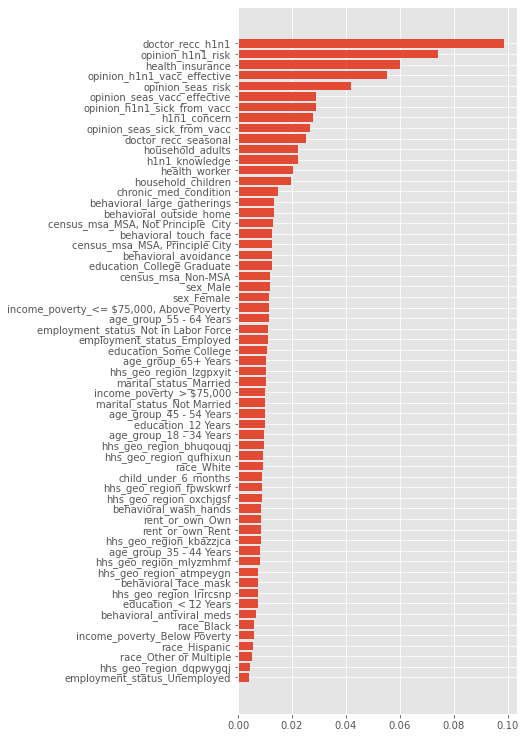

In [33]:
plot_feature_importances(rfc)

### Grid search on Random Forest Classifier

In [35]:
# gs_test = GridSearchCV(
#     rfc, 
#     param_grid={}, 
#     scoring="recall", 
#     cv=5,
#     refit="AUC",
#     return_train_score=True
# )

#### RFC Grid Search 1

In [36]:
grid2 = {
    'n_estimators': [10, 100, 1000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [3, 5, 7, 9],
    'max_features': ['auto', 'sqrt', 'log2']
}

gs2 = GridSearchCV(
    rfc, 
    param_grid=grid2, 
    cv=5
)

In [37]:
gs2.fit(X_train_scaled, y_train)
# WARNING: Took 54 minutes to run

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=50),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [3, 5, 7, 9],
                         'n_estimators': [10, 100, 1000]})

In [38]:
gs2.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'auto',
 'min_samples_split': 5,
 'n_estimators': 1000}

In [92]:
model_cv_results(gs2.best_estimator_, X_train_scaled, y_train)

,train_scores,cv_scores
accuracy,0.869695,0.848927
precision,0.885362,0.811929
recall,0.441114,0.372433
f1,0.588847,0.510462
roc_auc,0.907669,0.861097


#### RFC Grid Search 2

In [41]:
grid3 = {
    'n_estimators': [500, 1000, 1500],
    'criterion': ['gini'],
    'max_depth': [9, 11, 13, 15],
    'min_samples_split': [5],
    'max_features': ['auto', 'sqrt', 'log2']
}

gs3 = GridSearchCV(
    rfc, 
    param_grid=grid3,
    cv=5
)

In [42]:
gs3.fit(X_train_scaled, y_train)
# WARNING: Took 32 minutes to run

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=50),
             param_grid={'criterion': ['gini'], 'max_depth': [9, 11, 13, 15],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [5],
                         'n_estimators': [500, 1000, 1500]})

In [43]:
gs3.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_split': 5,
 'n_estimators': 1000}

In [78]:
model_cv_results(gs3.best_estimator_, X_train_scaled, y_train)

,train_scores,cv_scores
accuracy,0.939091,0.853520
precision,0.969791,0.784020
recall,0.734954,0.424594
f1,0.836198,0.550666
roc_auc,0.988629,0.864117


In [123]:
model_results(gs3.best_estimator_, X_test_scaled, y_test)

{'accuracy': 0.8404972292945934,
 'precision': 0.746684350132626,
 'recall': 0.3917884481558803,
 'f1': 0.5139205842081243,
 'roc_auc': 0.845674300254453}

In [45]:
###

In [48]:
# grid4 = {
#     'n_estimators': [500, 1000, 5000],
#     'criterion': ['gini'],
#     'max_depth': [15, 40, 65],
#     'min_samples_split': [5, 30, 55],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# gs4 = GridSearchCV(
#     rfc,
#     grid4,
#     cv=5
# )

# gs4.fit(X_train_scaled, y_train)
# # WARNING: 